# Malaria Predictive XGBOOST  ModeL

## Data Understanding

In [149]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [150]:
malaria_df = pd.read_csv("Data\Malaria_weekly.csv")
malaria_df.head()


,Date,Combined positive
0,12/31/2018,66
1,1/7/2019,110
2,1/14/2019,73
3,1/21/2019,70
4,1/28/2019,48


In [151]:
print(malaria_df.describe())           # datatypes + missing values

            Date Combined positive
count        349               349
unique       349               324
top     9/1/2025                13
freq           1                 5


In [152]:


# 2. Column data types
print("\nColumn data types:")
print(malaria_df.dtypes)

# 3. Summary of missing values
print("\nMissing values per column:")
print(malaria_df.isnull().sum())

# 4. Percentage of missing values
print("\nPercentage of missing values per column:")
print((malaria_df.isnull().mean() * 100).round(2))

# 5. Any duplicated rows?
print("\nNumber of duplicated rows:", malaria_df.duplicated().sum())

# 6. Quick look at numeric columns (summary stats)
print("\nDescriptive statistics:")
print(malaria_df.describe())

# 7. Check if Combined column = mRDT + Microscopy (if columns exist)
if {'mRDT_positive', 'Microscopy_positive', 'Combined_positive'}.issubset(malaria_df.columns):
    diff = malaria_df['Combined_positive'] - (
        malaria_df['mRDT_positive'].fillna(0) + malaria_df['Microscopy_positive'].fillna(0)
    )
    inconsistent = (diff != 0).sum()
    print(f"\nCombined mismatch rows: {inconsistent}")
    if inconsistent > 0:
        print("Sample mismatches:")
        print(malaria_df.loc[diff != 0, ['Date','mRDT_positive','Microscopy_positive','Combined_positive']].head())

# 8. Check date range continuity (weekly, Monday start)
if 'Date' in malaria_df.columns:
    malaria_weekly = malaria_df.sort_values('Date')
    expected = pd.date_range(
        start=malaria_weekly['Date'].min(),
        end=malaria_weekly['Date'].max(),
        freq='7D'
    )
    missing_weeks = expected.difference(malaria_weekly['Date'])
    print(f"\nNumber of missing weeks: {len(missing_weeks)}")
    if len(missing_weeks) > 0:
        print("Missing weeks (first 10):", missing_weeks[:10])



Column data types:
Date                 object
Combined positive    object
dtype: object

Missing values per column:
Date                 0
Combined positive    0
dtype: int64

Percentage of missing values per column:
Date                 0.0
Combined positive    0.0
dtype: float64

Number of duplicated rows: 0

Descriptive statistics:
            Date Combined positive
count        349               349
unique       349               324
top     9/1/2025                13
freq           1                 5

Number of missing weeks: 37
Missing weeks (first 10): DatetimeIndex(['2024-01-01', '2024-01-08', '2024-01-15', '2024-01-22',
               '2024-01-29', '2024-02-05', '2024-02-12', '2024-02-19',
               '2024-02-26', '2024-03-04'],
              dtype='datetime64[ns]', freq='7D')


In [153]:
# Convert Date to datetime
malaria_df["Date"] = pd.to_datetime(malaria_df["Date"], errors="coerce")

# Convert Combined positive to numeric (int)
malaria_df["Combined positive"] = pd.to_numeric(
    malaria_df["Combined positive"], errors="coerce"
).astype("Int64")   # Int64 allows for missing values

# Rename column to Cases
Weekly_malaria = malaria_df.rename(columns={"Combined positive": "Cases"})

# Confirm
print(Weekly_malaria.dtypes)
print(Weekly_malaria.head())


Date     datetime64[ns]
Cases             Int64
dtype: object
        Date  Cases
0 2018-12-31     66
1 2019-01-07    110
2 2019-01-14     73
3 2019-01-21     70
4 2019-01-28     48


In [154]:
malaria_df = malaria_df.rename(columns={'Combined positive': 'Cases'})

# Step 3: Confirm change
print(malaria_df.columns)




Index(['Date', 'Cases'], dtype='object')


In [155]:
malaria_df.head()

,Date,Cases
0,2018-12-31,66
1,2019-01-07,110
2,2019-01-14,73
3,2019-01-21,70
4,2019-01-28,48


In [156]:
# Rename malaria_df to Weekly_malaria
Weekly_malaria = malaria_df

# Check
print(Weekly_malaria.head())


        Date  Cases
0 2018-12-31     66
1 2019-01-07    110
2 2019-01-14     73
3 2019-01-21     70
4 2019-01-28     48


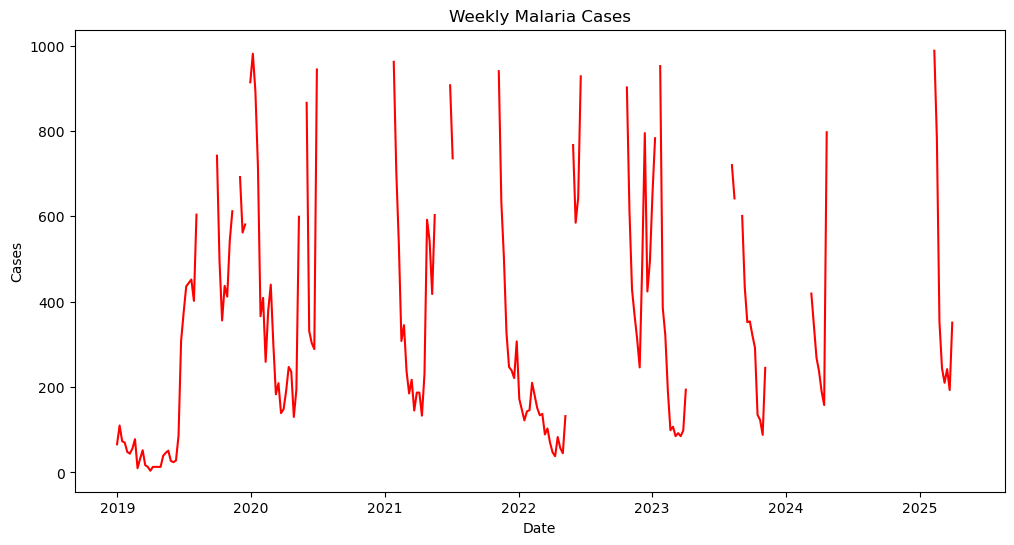

In [157]:
plt.figure(figsize=(12,6))
plt.plot(Weekly_malaria["Date"], Weekly_malaria["Cases"], color="red")
plt.title("Weekly Malaria Cases")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()


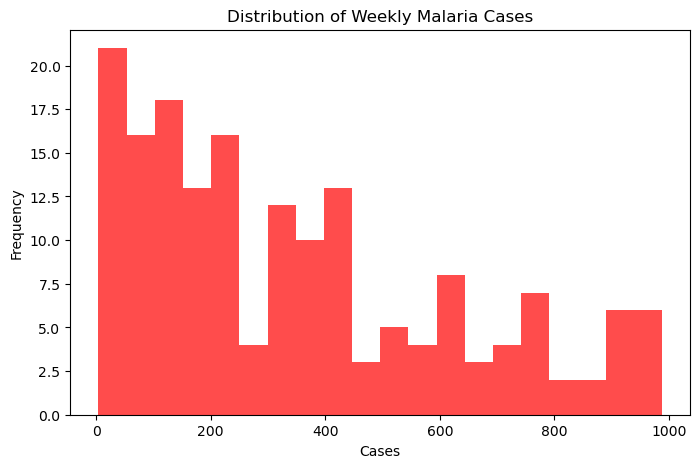

In [158]:
Weekly_malaria["Cases"].plot(kind="hist", bins=20, figsize=(8,5), color="red", alpha=0.7)
plt.title("Distribution of Weekly Malaria Cases")
plt.xlabel("Cases")
plt.show()


In [159]:
weather_df = pd.read_csv("Data/Weather_dataset.csv")
weather_df.head()

C:\Users\kyalo\AppData\Local\Temp\ipykernel_332\1309867547.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = pd.read_csv("Data/Weather_dataset.csv")


,Date,temperature_2m (Â°C),relative_humidity(%),dew_point_2m (Â°C),apparent_temperature(°C),precipitation (mm),rain(mm),snowfall (cm),snow_depth (m),weather_code (wmo code),...,wind_gusts_10m (km/h),wind_direction_100m (Â°),soil_temperature_0_to_7cm (Â°C),soil_temperature_7_to_28cm (Â°C),soil_temperature_28_to_100cm (Â°C),soil_temperature_100_to_255cm (Â°C),soil_moisture_0_to_7cm (mÂ³/mÂ³),soil_moisture_7_to_28cm (mÂ³/mÂ³),soil_moisture_28_to_100cm (mÂ³/mÂ³),soil_moisture_100_to_255cm (mÂ³/mÂ³)
0,2018-01-01T00:00,26.9,26,5.6,24.2,0.0,0.0,0,0,0,...,16.6,133.0,28.8,33.7,32.5,32.3,0.027,0.09,0.095,0.136
1,2018-01-01T01:00,25.9,27,5.6,23.2,0.0,0.0,0,0,0,...,15.5,167.0,27.7,33.4,32.5,32.3,0.027,0.09,0.095,0.136
2,2018-01-01T02:00,24.7,30,5.7,22.1,0.0,0.0,0,0,1,...,14.4,193.0,26.7,33.2,32.5,32.3,0.027,0.09,0.095,0.136
3,2018-01-01T03:00,24.6,31,6.6,21.1,0.0,0.0,0,0,2,...,26.6,188.0,24.7,32.7,32.5,32.3,0.027,0.09,0.095,0.136
4,2018-01-01T04:00,24.3,39,9.6,21.5,0.0,0.0,0,0,1,...,27.0,194.0,24.7,32.4,32.5,32.3,0.027,0.09,0.095,0.136


In [160]:
weather_df_truncated = weather_df[["Date","apparent_temperature(°C)","rain(mm)","relative_humidity(%)","wind_speed_10m(km/h)"]]
weather_df_truncated

,Date,apparent_temperature(°C),rain(mm),relative_humidity(%),wind_speed_10m(km/h)
0,2018-01-01T00:00,24.2,0.0,26,11.0
1,2018-01-01T01:00,23.2,0.0,27,10.5
2,2018-01-01T02:00,22.1,0.0,30,10.5
3,2018-01-01T03:00,21.1,0.0,31,18.0
4,2018-01-01T04:00,21.5,0.0,39,18.4
...,...,...,...,...,...
70372,9/11/2025,21.4,35.8,27.6,5
70373,9/12/2025,22.6,37.7,29.1,0
70374,9/13/2025,22.3,32.9,26.8,0.5
70375,9/14/2025,22,35.4,26.6,0


In [161]:

# Rename columns
weather_df_truncated = weather_df_truncated.rename(columns={
    "Date": "Date",
    "apparent_temperature(°C)": "Temparature",
    "rain(mm)": "Rainfall",
    "relative_humidity(%)": "Humidity",
    "wind_speed_10m(km/h)": "Wind"
})

weather_df_truncated.head()


,Date,Temparature,Rainfall,Humidity,Wind
0,2018-01-01T00:00,24.2,0.0,26,11.0
1,2018-01-01T01:00,23.2,0.0,27,10.5
2,2018-01-01T02:00,22.1,0.0,30,10.5
3,2018-01-01T03:00,21.1,0.0,31,18.0
4,2018-01-01T04:00,21.5,0.0,39,18.4


In [162]:

weather_df_truncated['Date'] = pd.to_datetime(weather_df_truncated['Date'], errors='coerce')
weather_df_truncated = weather_df_truncated.dropna(subset=['Date'])

# Convert weather columns to numeric (coerce bad strings to NaN)
for col in ['Temparature', 'Rainfall', 'Humidity', 'Wind']:
    weather_df_truncated[col] = pd.to_numeric(weather_df_truncated[col], errors='coerce')

# Drop rows where all weather values are missing
weather_df_truncated = weather_df_truncated.dropna(subset=['Temparature','Rainfall','Humidity','Wind'], how='all')

# Resample weekly (Mon–Sun), aggregate features
weather_weekly = weather_df_truncated.resample('W-SUN', on='Date').agg({
    'Temparature': 'mean',
    'Rainfall': 'sum',
    'Humidity': 'mean',
    'Wind': 'mean'
}).reset_index()

# Adjust to Monday as the start of the week
weather_weekly['Date'] = weather_weekly['Date'] - pd.to_timedelta(6, unit='d')

# Round for readability
weather_weekly = weather_weekly.round(2)

print(weather_weekly.head())



        Date  Temparature  Rainfall  Humidity   Wind
0 2018-01-01        27.75       0.0     23.85  11.35
1 2018-01-08        26.70       0.0     24.03  17.22
2 2018-01-15        27.47       0.0     25.36  15.36
3 2018-01-22        28.41       1.0     31.33  16.06
4 2018-01-29        28.59       0.0     30.30  18.11


In [163]:
# Rename malaria_df to Weekly_malaria
Weekly_weather = weather_weekly

# Check
print(Weekly_weather.head())

        Date  Temparature  Rainfall  Humidity   Wind
0 2018-01-01        27.75       0.0     23.85  11.35
1 2018-01-08        26.70       0.0     24.03  17.22
2 2018-01-15        27.47       0.0     25.36  15.36
3 2018-01-22        28.41       1.0     31.33  16.06
4 2018-01-29        28.59       0.0     30.30  18.11


In [164]:
# Check datatypes
print("Data types:\n", Weekly_weather.dtypes, "\n")

# Check for nulls / missing values
print("Missing values per column:\n", Weekly_weather.isnull().sum(), "\n")

# Check for any NA at all
print("Any nulls in dataset?:", Weekly_weather.isnull().values.any(), "\n")

# Summary info
print("Dataset info:")
print(Weekly_weather.info())


Data types:
 Date           datetime64[ns]
Temparature           float64
Rainfall              float64
Humidity              float64
Wind                  float64
dtype: object 

Missing values per column:
 Date           0
Temparature    0
Rainfall       0
Humidity       0
Wind           0
dtype: int64 

Any nulls in dataset?: False 

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         403 non-null    datetime64[ns]
 1   Temparature  403 non-null    float64       
 2   Rainfall     403 non-null    float64       
 3   Humidity     403 non-null    float64       
 4   Wind         403 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 15.9 KB
None


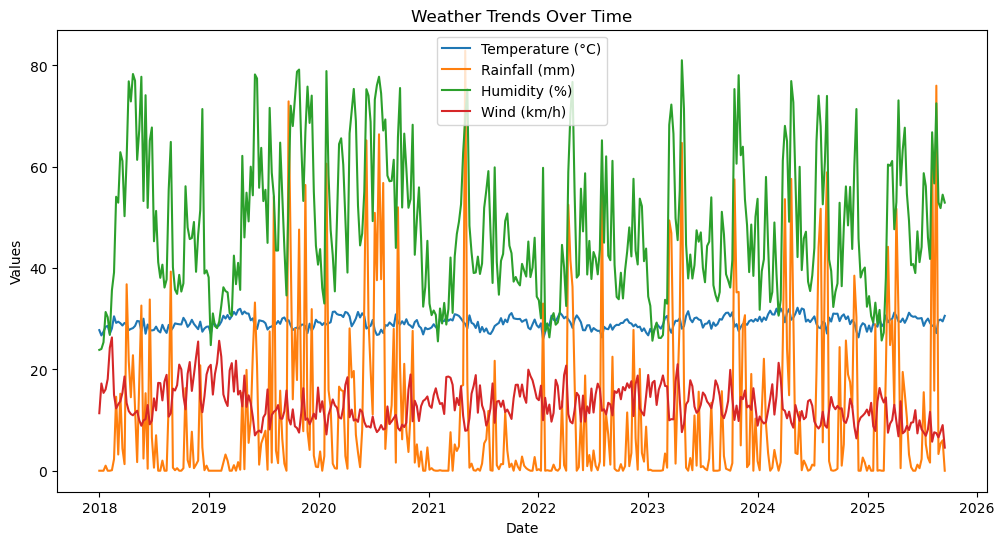

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(Weekly_weather["Date"], Weekly_weather["Temparature"], label="Temperature (°C)")
plt.plot(Weekly_weather["Date"], Weekly_weather["Rainfall"], label="Rainfall (mm)")
plt.plot(Weekly_weather["Date"], Weekly_weather["Humidity"], label="Humidity (%)")
plt.plot(Weekly_weather["Date"], Weekly_weather["Wind"], label="Wind (km/h)")
plt.legend()
plt.title("Weather Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()


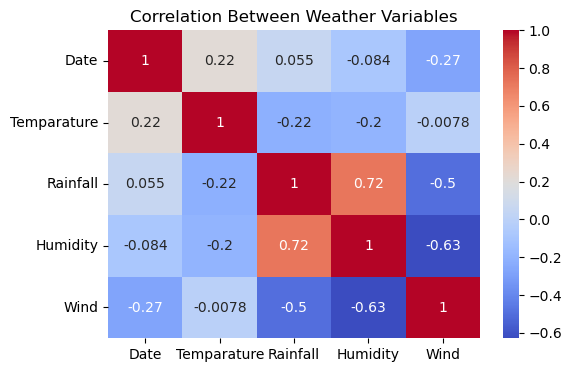

In [166]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(Weekly_weather.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Weather Variables")
plt.show()


In [167]:
# Merge Weekly_malaria and Weekly_weather on Date
merged_df = pd.merge(
    Weekly_malaria,
    Weekly_weather,
    on="Date",        # column to join on
    how="inner"       # inner join keeps only matching dates
)

# Check result
print(merged_df.head())
print("Shape:", merged_df.shape)


        Date  Cases  Temparature  Rainfall  Humidity   Wind
0 2018-12-31     66        28.47       0.0     38.17  20.40
1 2019-01-07    110        27.04       0.0     24.79  20.90
2 2019-01-14     73        29.02       0.0     31.05  15.03
3 2019-01-21     70        28.92       0.0     28.55  19.12
4 2019-01-28     48        28.40       0.0     28.14  21.28
Shape: (349, 6)


In [168]:
print(merged_df.describe())

                      Date       Cases  Temparature    Rainfall    Humidity  \
count                  349       173.0   349.000000  349.000000  349.000000   
mean   2022-05-02 00:00:00  350.040462    29.317679   11.128367   48.173324   
min    2018-12-31 00:00:00         4.0    25.970000    0.000000   24.790000   
25%    2020-08-31 00:00:00       132.0    28.500000    0.200000   37.840000   
50%    2022-05-02 00:00:00       289.0    29.300000    2.700000   45.010000   
75%    2024-01-01 00:00:00       542.0    30.080000   15.900000   58.250000   
max    2025-09-01 00:00:00       988.0    32.180000   82.900000   81.020000   
std                    NaN  274.660348     1.191270   16.680830   13.945770   

             Wind  
count  349.000000  
mean    12.679943  
min      5.730000  
25%     10.000000  
50%     12.240000  
75%     14.790000  
max     25.650000  
std      3.484493  


In [169]:
# 1. Make sure Date is datetime
merged_df["Date"] = pd.to_datetime(merged_df["Date"], errors="coerce")

# 2. Drop duplicate rows (if any)
merged_df = merged_df.drop_duplicates()

# 3. Drop rows where Date is missing (after coercion)
merged_df = merged_df.dropna(subset=["Date"])

# 4. Check for nulls in numeric columns and handle them
# Fill with 0 for cases (disease counts), interpolate for weather
if "Cases" in merged_df.columns:
    merged_df["Cases"] = pd.to_numeric(merged_df["Cases"], errors="coerce").fillna(0).astype(int)

for col in ["Temparature", "Rainfall", "Humidity", "Wind"]:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")
        merged_df[col] = merged_df[col].interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")

# 5. Reindex to ensure no missing weeks (fill gaps with NaN then fix)
full_range = pd.date_range(start=merged_df["Date"].min(), 
                           end=merged_df["Date"].max(), freq="W-MON")  # weekly Mondays
merged_df = merged_df.set_index("Date").reindex(full_range).rename_axis("Date").reset_index()

# 6. Fill again (after reindexing)
if "Cases" in merged_df.columns:
    merged_df["Cases"] = merged_df["Cases"].fillna(0).astype(int)

for col in ["Temparature", "Rainfall", "Humidity", "Wind"]:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")

# ✅ Final check
print("Null values per column:\n", merged_df.isnull().sum())
print("Data types:\n", merged_df.dtypes)
print("Shape:", merged_df.shape)


Null values per column:
 Date           0
Cases          0
Temparature    0
Rainfall       0
Humidity       0
Wind           0
dtype: int64
Data types:
 Date           datetime64[ns]
Cases                   int64
Temparature           float64
Rainfall              float64
Humidity              float64
Wind                  float64
dtype: object
Shape: (349, 6)


C:\Users\kyalo\AppData\Local\Temp\ipykernel_332\2854247117.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[col] = merged_df[col].interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")
C:\Users\kyalo\AppData\Local\Temp\ipykernel_332\2854247117.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[col] = merged_df[col].interpolate(method="linear").fillna(method="bfill").fillna(method="ffill")


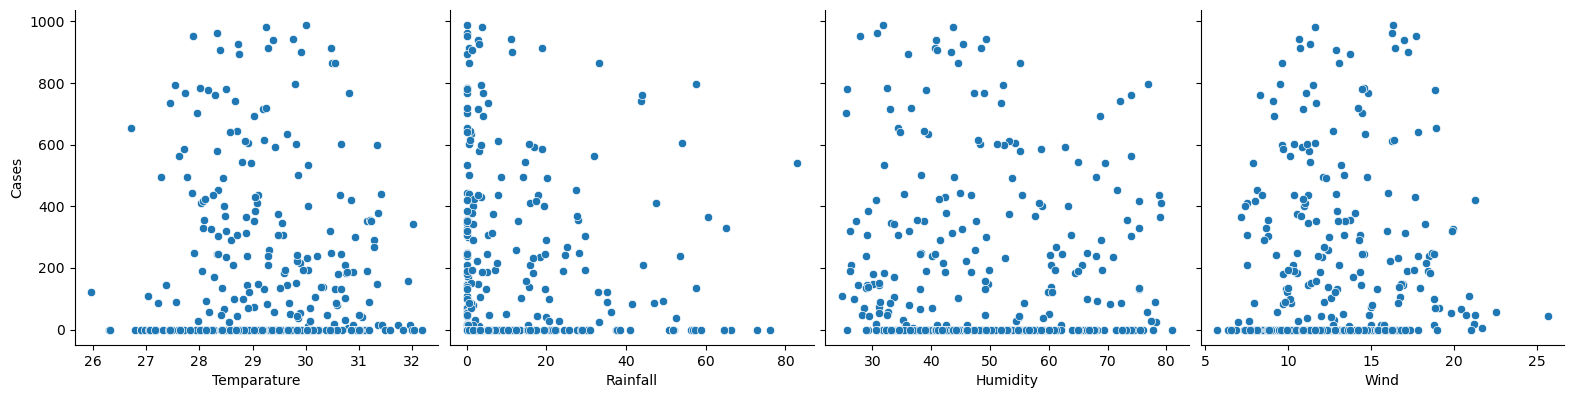

In [170]:
sns.pairplot(merged_df, x_vars=["Temparature","Rainfall","Humidity","Wind"], 
             y_vars="Cases", height=4, aspect=1, kind="scatter")


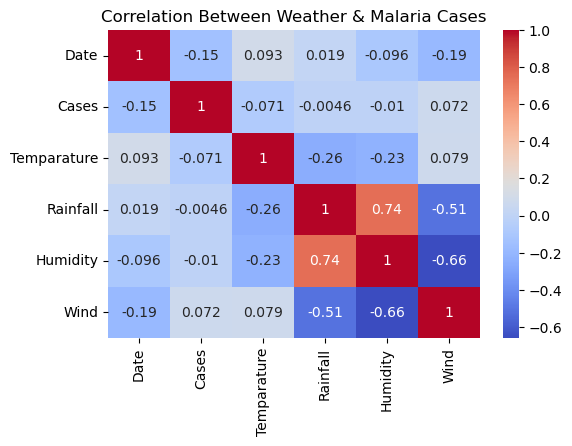

In [171]:
plt.figure(figsize=(6,4))
sns.heatmap(merged_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Weather & Malaria Cases")
plt.show()


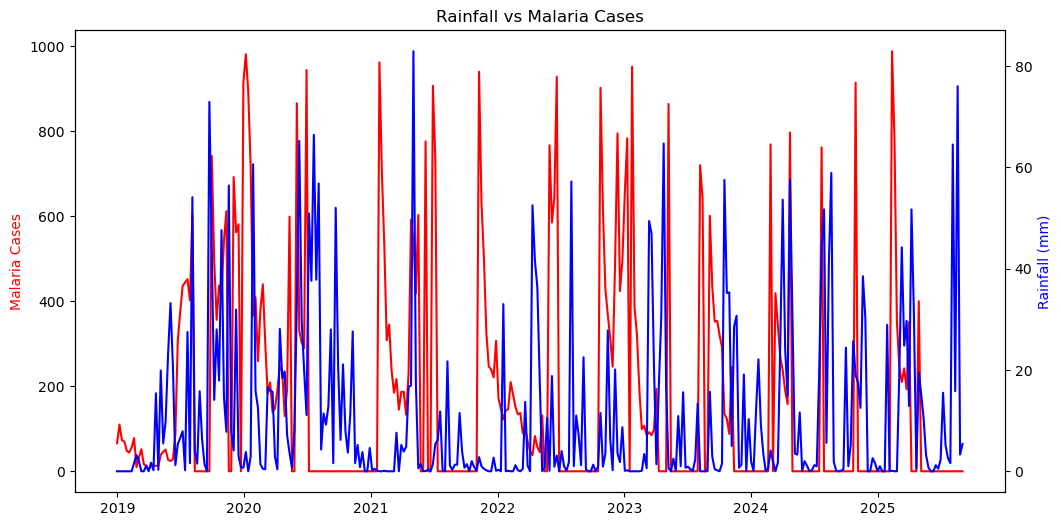

In [172]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(merged_df["Date"], merged_df["Cases"], color="red", label="Malaria Cases")
ax1.set_ylabel("Malaria Cases", color="red")

ax2 = ax1.twinx()
ax2.plot(merged_df["Date"], merged_df["Rainfall"], color="blue", label="Rainfall")
ax2.set_ylabel("Rainfall (mm)", color="blue")

plt.title("Rainfall vs Malaria Cases")
plt.show()


In [173]:
# Make a copy
df_lagged = merged_df.copy()

# Ensure numeric columns are clean
numeric_cols = ["Cases", "Rainfall", "Temparature", "Humidity", "Wind"]
for col in numeric_cols:
    df_lagged[col] = (
        df_lagged[col]
        .replace({',': '', '#VALUE!': None}, regex=True)  # remove commas & replace bad strings
    )
    df_lagged[col] = pd.to_numeric(df_lagged[col], errors="coerce")  # force to numeric

# Define how many weeks to lag
max_lag = 6  

# Features to lag (weather + cases)
features_to_lag = ["Cases", "Rainfall", "Temparature", "Humidity", "Wind"]

# Create lag features
for feature in features_to_lag:
    for lag in range(1, max_lag + 1):
        df_lagged[f"{feature}_lag{lag}"] = df_lagged[feature].shift(lag)

# Drop rows with NaN caused by lagging
df_lagged = df_lagged.dropna().reset_index(drop=True)

# Correlation with target
corrs = df_lagged.corr(numeric_only=True)["Cases"].sort_values(ascending=False)

print(" Top correlations with malaria cases:")
print(corrs.head(15))
print("\n Lowest correlations with malaria cases:")
print(corrs.tail(15))


 Top correlations with malaria cases:
Cases            1.000000
Cases_lag1       0.442164
Cases_lag3       0.287302
Cases_lag2       0.279116
Cases_lag4       0.236060
Cases_lag5       0.129537
Cases_lag6       0.113302
Wind_lag4        0.110538
Wind_lag5        0.100358
Wind             0.093213
Wind_lag3        0.093006
Wind_lag1        0.079048
Wind_lag2        0.033943
Wind_lag6        0.027938
Humidity_lag1   -0.003140
Name: Cases, dtype: float64

 Lowest correlations with malaria cases:
Humidity           -0.019372
Humidity_lag2      -0.026505
Rainfall_lag1      -0.026801
Temparature_lag3   -0.042047
Rainfall_lag3      -0.050597
Temparature_lag6   -0.052050
Humidity_lag4      -0.062977
Temparature_lag2   -0.063554
Humidity_lag5      -0.076863
Temparature        -0.076901
Humidity_lag3      -0.080919
Rainfall_lag4      -0.081819
Rainfall_lag6      -0.097183
Temparature_lag1   -0.099495
Rainfall_lag5      -0.102909
Name: Cases, dtype: float64


In [174]:
# Define target
target = "Cases"   
# Define final selected features based on TOP correlations
features = [
    "Cases_lag1",
    "Cases_lag2",
    "Cases_lag3",
    "Cases_lag4",
    "Cases_lag5",
    "Cases_lag6",
    "Wind_lag4",
    "Wind_lag5"
]

# Create X (features) and y (target)
X = df_lagged[features]
y = df_lagged[target]

print("✅ Final feature set:")
print(X.head())
print("\n🎯 Target sample:")
print(y.head())



✅ Final feature set:
   Cases_lag1  Cases_lag2  Cases_lag3  Cases_lag4  Cases_lag5  Cases_lag6  \
0        44.0        48.0        70.0        73.0       110.0        66.0   
1        56.0        44.0        48.0        70.0        73.0       110.0   
2        78.0        56.0        44.0        48.0        70.0        73.0   
3        10.0        78.0        56.0        44.0        48.0        70.0   
4        32.0        10.0        78.0        56.0        44.0        48.0   

   Wind_lag4  Wind_lag5  
0      15.03      20.90  
1      19.12      15.03  
2      21.28      19.12  
3      25.65      21.28  
4      22.51      25.65  

🎯 Target sample:
0    56
1    78
2    10
3    32
4    52
Name: Cases, dtype: int64


In [175]:
# Manual split for time series (keeps order strictly)
split = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)



Train shape: (274, 8) (274,)
Test shape: (69, 8) (69,)


In [176]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define the XGBoost model
xgb_model = XGBRegressor(
   n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# --- Evaluation metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# --- MASE calculation ---
# naive forecast = previous actual value
naive_forecast = y_test.shift(1)
naive_mae = np.mean(np.abs(y_test[1:].values - naive_forecast[1:].values))
mase = mae / naive_mae

print("XGBoost Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MASE: {mase:.3f}")




XGBoost Model Performance:
RMSE: 249.09
MAE: 133.45
R²: -0.345
MASE: 1.394


<Figure size 800x600 with 0 Axes>

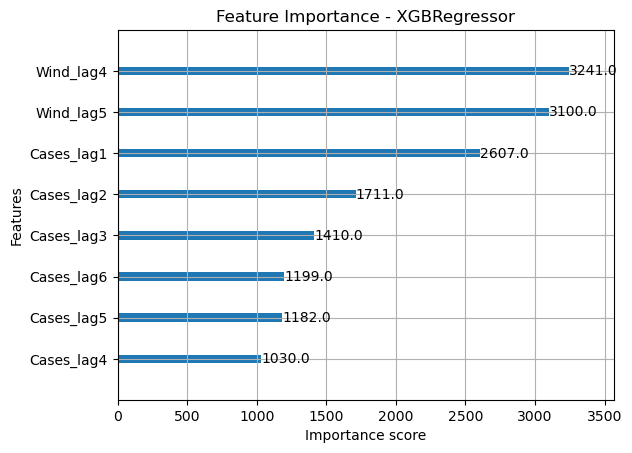

In [177]:

from xgboost import plot_importance


plt.figure(figsize=(8, 6))
plot_importance(xgb_model, importance_type='weight')  # 'weight', 'gain', or 'cover'
plt.title("Feature Importance - XGBRegressor")
plt.show()




In [178]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint, uniform
import numpy as np

# Base model
xgb_reg = XGBRegressor(random_state=42)

# Time-series aware split
tscv = TimeSeriesSplit(n_splits=3)

# Parameter space
param_dist = {
    "n_estimators": randint(200, 1500),
    "learning_rate": uniform(0.01, 0.1),
    "max_depth": randint(3, 8),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 6),
    "gamma": uniform(0, 0.5),
    "reg_alpha": uniform(0, 0.5),
    "reg_lambda": uniform(0.5, 1)
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=50,
    scoring="r2",
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Evaluate
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Calculate MASE
naive_forecast = y_test.shift(1).bfill()
mase = mae / np.mean(np.abs(y_test - naive_forecast))

print("\nImproved XGBoost Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"MASE: {mase:.3f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': np.float64(0.6156745306702585), 'gamma': np.float64(0.20897301585778938), 'learning_rate': np.float64(0.10675805515202474), 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 656, 'reg_alpha': np.float64(0.28426014187497917), 'reg_lambda': np.float64(1.0759245752580846), 'subsample': np.float64(0.892659102119856)}

Improved XGBoost Model Performance:
RMSE: 249.41
MAE: 128.86
R²: -0.349
MASE: 1.366



 ## Takeaway on XGBoost Model Performance

XGBoost Model Performance:
  - RMSE: **249.09**
  - MAE: **133.45**
  - R²: **-0.345**
  - MASE: **1.394**

 **Improved XGBoost Model Performance:**
  - RMSE: **249.41**
  - MAE: **128.86**
  - R²: **-0.349**
  - MASE: **1.366**

  



- The XGBoost regression model **did not perform well** in forecasting malaria outbreaks.  
- Both the baseline and tuned versions produced **negative R² values**, showing that the model performed worse than a simple average-based baseline.  
- The errors (RMSE and MAE) remained relatively high, indicating weak predictive power.  
- XGBoost is **not reliable for time-series forecasting** in this case.  
